# Packages and Data Split

In [169]:
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import numpy as np
from hmmlearn import hmm
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [152]:
aapl = yf.download("AAPL", start="2010-01-01", end="2021-10-31").reset_index()
aapl.Date = pd.to_datetime(aapl.Date)

[*********************100%***********************]  1 of 1 completed


In [154]:
train,test = aapl[aapl.Date<'2021-01-01'],aapl[aapl.Date>='2021-01-01']

In [155]:
train_np = np.array(train.Close).reshape(-1,1)
test_np = np.array(test.Close).reshape(-1,1)

In [156]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
remodel.fit(train_np)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000)

In [160]:
plot_data = train_np[1500:]
predict_state = remodel.predict(plot_data)

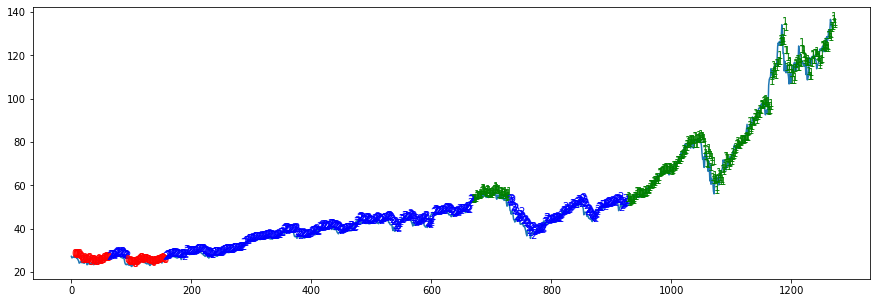

In [161]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(plot_data)
color_set = ['r','g','b']
for i, txt in enumerate(predict_state):
    plt.annotate(int(txt), (i, plot_data[i]),c=colormap[int(txt)])

# markov_autoregression

In [176]:
hmm_model = MarkovAutoregression(train_np,k_regimes = 3,order = 6)

In [177]:
hmm_model.fit()

LinAlgError: SVD did not converge

# ARIMA Prediction

In [136]:
model = ARIMA(train['Close'],order = (5,2,2))

In [144]:
model_fit = model.fit()

0         0.000000
1         7.166997
2         4.754135
3         4.208190
4         3.550584
           ...    
2642    646.559323
2643    663.811205
2644    665.351023
2645    670.617720
2646    695.919844
Length: 2647, dtype: float64

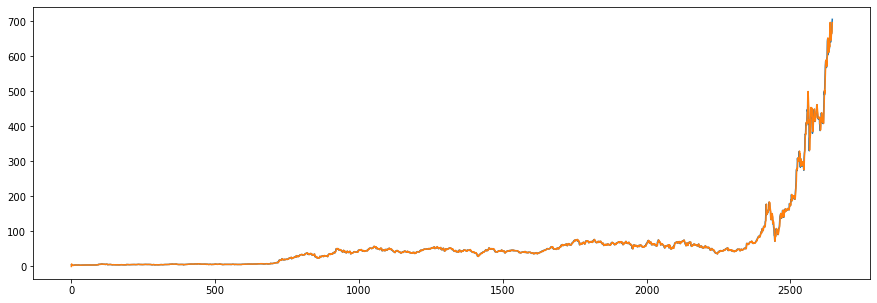

In [148]:
plt.plot(train_np)
plt.plot(model_fit.predict())

In [139]:
model_refit = model.update(test.Close)

In [151]:
model_refit

array([ 729.77001953,  735.10998535,  755.97998047,  816.03997803,
        880.02001953,  811.19000244,  849.44000244,  854.40997314,
        845.        ,  826.15997314,  844.54998779,  850.45001221,
        844.98999023,  846.64001465,  880.79998779,  883.09002686,
        864.15997314,  835.42999268,  793.5300293 ,  839.80999756,
        872.78997803,  854.69000244,  849.98999023,  852.22998047,
        863.41998291,  849.46002197,  804.82000732,  811.65997314,
        816.11999512,  796.2199707 ,  798.15002441,  787.38000488,
        781.29998779,  714.5       ,  698.84002686,  742.02001953,
        682.2199707 ,  675.5       ,  718.42999268,  686.44000244,
        653.20001221,  621.44000244,  597.95001221,  563.        ,
        673.58001709,  668.05999756,  699.59997559,  693.72998047,
        707.94000244,  676.88000488,  701.80999756,  653.15997314,
        654.86999512,  670.        ,  662.15997314,  630.27001953,
        640.39001465,  618.71002197,  611.28997803,  635.61999

In [140]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2647
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -8048.679
Date:                Thu, 18 Nov 2021   AIC                          16113.358
Time:                        16:31:26   BIC                          16160.402
Sample:                             0   HQIC                         16130.389
                               - 2647                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9447      0.031    -30.219      0.000      -1.006      -0.883
ar.L2         -0.0360      0.007     -5.029      0.000      -0.050      -0.022
ar.L3          0.0514      0.006      8.140      0.0

In [141]:
print(model_refit.summary())

AttributeError: 'numpy.ndarray' object has no attribute 'summary'

In [85]:
model_fit.forecast(len(test))

2769    133.039942
2770    133.535988
2771    133.380505
2772    133.842607
2773    133.753033
           ...    
2973    174.194465
2974    174.395966
2975    174.597466
2976    174.798967
2977    175.000467
Length: 209, dtype: float64

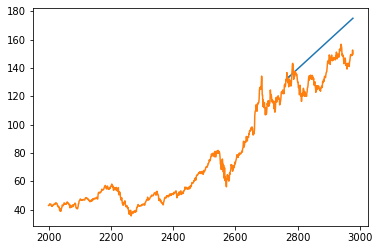

In [89]:
plt.plot(model_fit.forecast(len(test),alpha = 0.05))
plt.plot(aapl[2000:].Close)